In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg

In [102]:
file_path = '../input/data_clean_raw.csv'
# targ = 'LMCADY'

# window = 5
# file_path = '../input/copper_log_returns_{}d_final.csv'.format(window)

time_series = pd.read_csv(file_path, usecols=['Date', 'LMCADY'])
time_series['Date'] = pd.to_datetime(time_series['Date'])
time_series.set_index('Date', inplace=True)


In [103]:
# # Establece la frecuencia del índice, suponiendo que los datos son diarios
# time_series = time_series.asfreq('D')

# # Verifica que el índice sea monótono
# if not time_series.index.is_monotonic_increasing:
#     time_series = time_series.sort_index()

In [104]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.01, shuffle=False)
LMCADY_train

,LMCADY
Date,
2003-01-01,1542.50
2003-01-02,1573.40
2003-01-03,1594.75
2003-01-06,1611.20
2003-01-07,1604.00
...,...
2024-01-26,8448.05
2024-01-29,8455.00
2024-01-30,8511.75


In [105]:
LMCADY_test.tail(10)

,LMCADY
Date,
2024-04-08,9281.51
2024-04-09,9283.00
2024-04-10,9240.45
2024-04-11,9209.90
2024-04-12,9333.20
2024-04-15,9499.47
2024-04-16,9355.10
2024-04-17,9489.70
2024-04-18,9652.00


In [106]:
def evaluate_ar_model(train_series, test_series, lags=50):
    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))
    predictions = []
    current_train = train_series.copy()
    for actual in test_series:
        if len(current_train) <= lags:
            print(f"No hay suficientes observaciones para {lags} lags. Terminando el ciclo.")
            break

        model = AutoReg(current_train, lags=lags)
        model_fit = model.fit()

        prediction = model_fit.predict(start=len(current_train), end=len(current_train), dynamic=False)
        predictions.append(prediction.iloc[0])

        current_train = pd.concat([current_train, pd.Series([actual], index=[len(current_train)])])

    return pd.Series(predictions, index=test_series.index)

In [107]:
def calculate_rmse(predictions, actual):
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [108]:
def evaluate_and_store_best_ar_model(train_series, test_series, min_lags, max_lags):
    best_rmse = float('inf')
    best_predictions = None
    best_actuals = None
    best_lag = 0

    for lags in range(min_lags, max_lags + 1):
        try:
            predictions = evaluate_ar_model(train_series, test_series, lags=lags)
            rmse = np.sqrt(mean_squared_error(test_series, predictions))
            print(f"AR> RMSE {lags} lags: {rmse:.6f}")
            if rmse < best_rmse:
                best_rmse = rmse
                best_predictions = predictions
                best_actuals = test_series
                best_lag = lags
        except ValueError as e:
            print(f"Error con lag {lags}: {e}")

    return best_lag, best_rmse, best_predictions, best_actuals


In [109]:
def plot_ar_model_predictions(actuals, predictions, title="AR Model Predictions vs Actuals"):
    """
    Function to plot the predictions of an AR model against the actual values.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(actuals.index, actuals, label='Actual Values', color='blue')
    plt.plot(predictions.index, predictions, label='Predictions', color='red', linestyle='-')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [110]:
def clean_data(series):
    series = series.replace([np.inf, -np.inf], np.nan)  # Reemplaza infinitos por NaN
    series.dropna(inplace=True)  # Elimina cualquier fila con NaN
    return series

LMCADY_train_clean = clean_data(LMCADY_train.squeeze())
LMCADY_test_clean = clean_data(LMCADY_test.squeeze())

best_lag, best_rmse, best_predictions, best_actuals = evaluate_and_store_best_ar_model(LMCADY_train_clean, LMCADY_test_clean, min_lags = 50, max_lags=50)


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will

AR> RMSE 50 lags: 98.535184


/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fochoa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predic

Best lag: 50 and RMSE: 98.535184 vs data.std: LMCADY    435.813329
dtype: float64


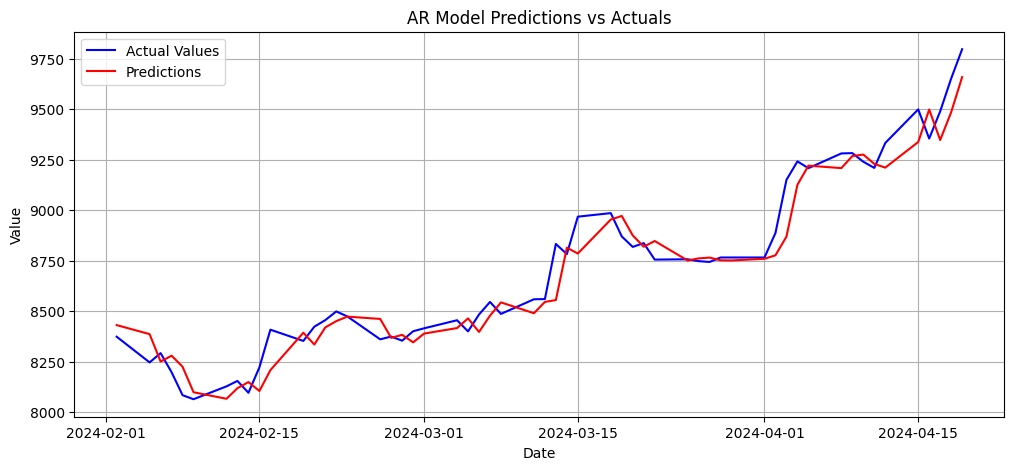

In [111]:
print("Best lag: {} and RMSE: {:.6f} vs data.std: {}".format(best_lag, best_rmse, LMCADY_test.std()))
plot_ar_model_predictions(best_actuals, best_predictions, title="AR Model Predictions vs Actuals")
